In [1]:
#load training state pickle
import pickle

path = "/mnt/sda1/FYP_2024/Helitha/XFeat/training_state.pkl"
with open(path, "rb") as f:
    training_state = pickle.load(f)
print(training_state.keys())


/home/fyp2selfdriving/anaconda3/envs/xfeat/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dict_keys(['step', 'optimizer_state', 'scheduler_state'])


In [2]:
import torch
trained_model_path = "/mnt/sda1/FYP_2024/Helitha/XFeat/latest_checkpoint.pth"
original_model_path = "/mnt/sda1/FYP_2024/Helitha/XFeat/xfeat.pt"

checkpoint = torch.load(trained_model_path, map_location="cpu")
print(checkpoint.keys())
print(checkpoint["model_state"].keys())
print()
checkpoint = torch.load(original_model_path, map_location="cpu")
print(checkpoint.keys())

dict_keys(['model_state'])
odict_keys(['skip1.1.weight', 'skip1.1.bias', 'block1.0.layer.0.weight', 'block1.0.layer.1.running_mean', 'block1.0.layer.1.running_var', 'block1.0.layer.1.num_batches_tracked', 'block1.1.layer.0.weight', 'block1.1.layer.1.running_mean', 'block1.1.layer.1.running_var', 'block1.1.layer.1.num_batches_tracked', 'block1.2.layer.0.weight', 'block1.2.layer.1.running_mean', 'block1.2.layer.1.running_var', 'block1.2.layer.1.num_batches_tracked', 'block1.3.layer.0.weight', 'block1.3.layer.1.running_mean', 'block1.3.layer.1.running_var', 'block1.3.layer.1.num_batches_tracked', 'block2.0.layer.0.weight', 'block2.0.layer.1.running_mean', 'block2.0.layer.1.running_var', 'block2.0.layer.1.num_batches_tracked', 'block2.1.layer.0.weight', 'block2.1.layer.1.running_mean', 'block2.1.layer.1.running_var', 'block2.1.layer.1.num_batches_tracked', 'block3.0.layer.0.weight', 'block3.0.layer.1.running_mean', 'block3.0.layer.1.running_var', 'block3.0.layer.1.num_batches_tracked', 'bl

# Load the model

In [8]:
import torch

#model_path = "/mnt/sda1/FYP_2024/Helitha/XFeat/latest_checkpoint.pth"
model_path = "/mnt/sda1/FYP_2024/Helitha/XFeat/xfeat.pt"
checkpoint = torch.load(model_path, map_location='cpu')  # map_location='cpu' is safe

print("Checkpoint type:", type(checkpoint))

checkpoint = torch.load(model_path, map_location='cpu')

# Handle raw state_dict or wrapped dict with 'model_state'
if isinstance(checkpoint, dict) and 'model_state' in checkpoint:
    state_dict = checkpoint['model_state']
else:
    state_dict = checkpoint  # assume it's already a state_dict

from xfeat import XFeat
model = XFeat(weights=state_dict)


Checkpoint type: <class 'collections.OrderedDict'>


## XFeat minimal inference example

In [9]:
#Random input
x = torch.randn(1,3,480,640)

#Simple inference with batch = 1
output = model.detectAndCompute(x, top_k = 4096)[0]
print("----------------")
print("keypoints: ", output['keypoints'].shape)
print("descriptors: ", output['descriptors'].shape)
print("scores: ", output['scores'].shape)
print("----------------\n")


import tqdm

x = torch.randn(1,3,480,640)
# Stress test
for i in tqdm.tqdm(range(100), desc="Stress test on VGA resolution"):
	output = model.detectAndCompute(x, top_k = 4096)


# Batched mode
x = torch.randn(4,3,480,640)
outputs = model.detectAndCompute(x, top_k = 4096)
print("# detected features on each batch item:", [len(o['keypoints']) for o in outputs])

# Match two images with sparse features
x1 = torch.randn(1,3,480,640)
x2 = torch.randn(1,3,480,640)
mkpts_0, mkpts_1 = model.match_xfeat(x1, x2)


# Create 4 image pairs
x1 = torch.randn(4,3,480,640)
x2 = torch.randn(4,3,480,640)

#Obtain matches for each batch item
matches_list = model.match_xfeat_star(x1, x2, top_k = 5000)
print('number of img pairs', len(matches_list))
print(matches_list[0].shape) # -> output is (x1,y1,x2,y2)

----------------
keypoints:  torch.Size([4096, 2])
descriptors:  torch.Size([4096, 64])
scores:  torch.Size([4096])
----------------



Stress test on VGA resolution: 100%|██████████| 100/100 [00:00<00:00, 248.36it/s]
/home/fyp2selfdriving/anaconda3/envs/xfeat/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


# detected features on each batch item: [4096, 4096, 4096, 4096]
number of img pairs 4
torch.Size([154, 4])


## XFeat matching example using torch hub


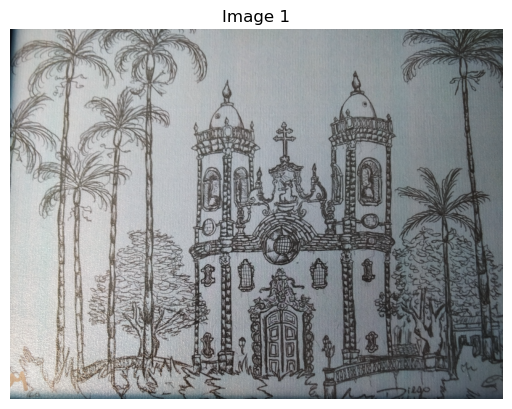

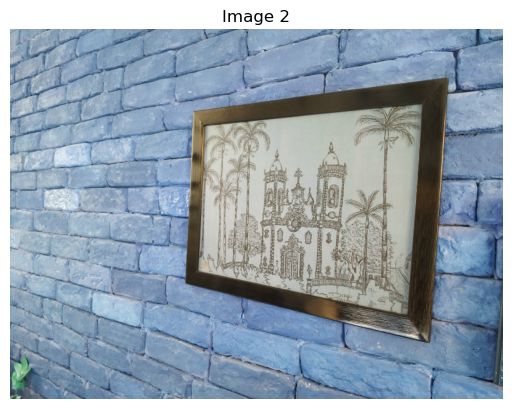

In [10]:
!pip install imageio
import imageio as imio
import numpy as np

#Load some example images
im1 = np.copy(imio.v2.imread('https://raw.githubusercontent.com/verlab/accelerated_features/main/assets/ref.png')[..., ::-1])
im2 = np.copy(imio.v2.imread('https://raw.githubusercontent.com/verlab/accelerated_features/main/assets/tgt.png')[..., ::-1])


#display the images
import matplotlib.pyplot as plt
def show_image(image, title=None):
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()
show_image(im1, "Image 1")
show_image(im2, "Image 2")


Loaded LightGlue model
number of matches:  794
number of inliers:  794
number of outliers:  0
inlier ratio:  0.9458438287153652


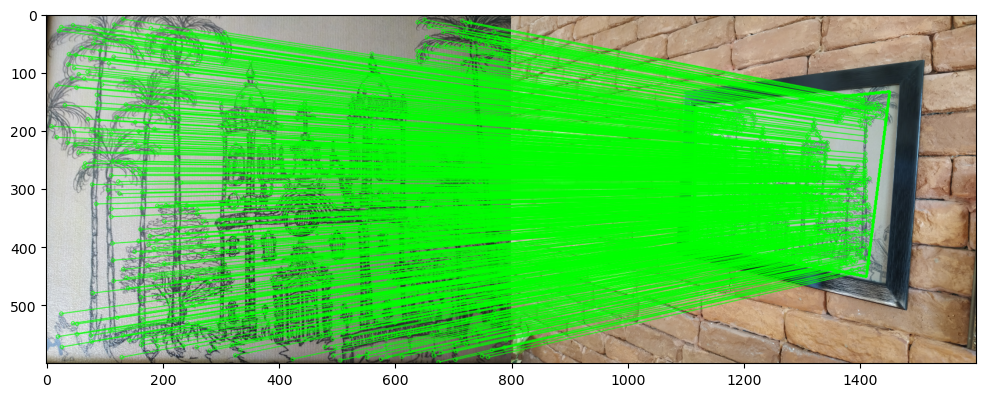

In [11]:
import cv2
import numpy as np

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    print('inlier ratio: ', np.sum(mask)/len(mask))

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches


import matplotlib.pyplot as plt

# Inference with batch = 1
output0 = model.detectAndCompute(im1, top_k=4096)[0]
output1 = model.detectAndCompute(im2, top_k=4096)[0]

# Update with image resolution (required)
output0.update({'image_size': (im1.shape[1], im1.shape[0])})
output1.update({'image_size': (im2.shape[1], im2.shape[0])})

# Matching with LightGlue
mkpts_0, mkpts_1, idxs = model.match_lighterglue(output0, output1)

# Debug prints
print('number of matches: ', len(mkpts_0))
print('number of inliers: ', len(idxs))
print('number of outliers: ', len(mkpts_0) - len(idxs))

# Only proceed if we have enough matches to compute homography
if len(mkpts_0) >= 4:
    canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
    plt.figure(figsize=(12, 12))
    plt.imshow(canvas[..., ::-1])
    plt.show()
else:
    print("Not enough matches to compute homography. Skipping visualization.")


docker run -it --rm \
  -v "$(pwd)":/workspace \
  -w /workspace \
  --gpus all \
  xilinx/vitis-ai-pytorch-gpu:3.5.0.001-1eed93cde \
  bash
